In [1]:
import numpy as np
import matplotlib.pyplot as plt
%run utils.py

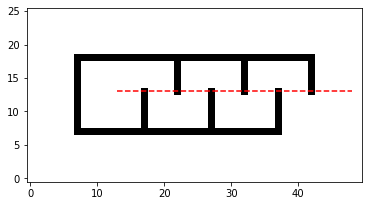

In [2]:
WO1 = [(-6,-6), (25,-6), (25,-5), (-6,-5)]
WO2 = [(-6,5),(30,5),(30,6),(-6,6)]
WO3 = [(-6,-5),(-5,-5),(-5,5),(-6,5)]
WO4 = [(4,-5),(5,-5),(5,1),(4,1)]
WO5 = [(9,0),(10,0),(10,5),(9,5)]
WO6 = [(14,-5),(15,-5),(15,1),(14,1)]
WO7 = [(19,0),(20,0),(20,5),(19,5)]
WO8 = [(24,-5),(25,-5),(25,1),(24,1)]
WO9 = [(29,0),(30,0),(30,5),(29,5)]

obstacles = [WO1, WO2, WO3, WO4, WO5, WO6, WO7, WO8, WO9]

qstart = (0,0)
qgoal = (35,0)

xmin = float('inf')
xmax = float('-inf')
ymin = float('inf')
ymax = float('-inf')

for obs in obstacles:
    xs = sorted(list(set([coord[0] for coord in obs])))
    ys = sorted(list(set([coord[1] for coord in obs])))
    if xs[0] < xmin: xmin = xs[0]
    if xs[1] > xmax: xmax = xs[1]
    if ys[0] < ymin: ymin = ys[0]
    if ys[1] > ymax: ymax = ys[1]


xrange, yrange = (xmax-xmin, ymax-ymin)
pad = 7

# Transform indices to only be positive with some padding
def transform(x,y):
    '''Real Position -> Translated Matrix Indices'''
    return (x+(pad-xmin),y+(pad-ymin))

def itransform(x,y):
    '''Translated Matrix Indices -> Real Position'''
    return (x-(pad-xmin),y-(pad-ymin))



qstart = transform(*qstart)
qgoal = transform(*qgoal)

W = np.zeros((xrange+2*pad,yrange+2*pad))

for obs in obstacles.copy():
    for i,(x,y) in enumerate(obs):
        obs[i] = transform(x,y)
        
    xs = sorted(list(set([coord[0] for coord in obs])))
    ys = sorted(list(set([coord[1] for coord in obs])))
    
    assert (len(xs),len(ys)) == (2,2)
    
    W[xs[0]:xs[1],ys[0]:ys[1]] = 1

plt.imshow(W.T,cmap='gray_r', origin='lower')
plt.plot(list(zip(qstart,qgoal))[0],list(zip(qstart,qgoal))[1], 'r--')

In [3]:
pos = np.array(qstart)
qgoal = np.array(qgoal)

move_history = pos.copy().reshape(1,-1)

while True:
    # Begin MTG Behavior
    while (pos != qgoal).any():
        move = MTG_move(pos, qgoal)
        if isMoveValid(pos, move, W):
            pos += move
            move_history = add_pos(move_history, pos)
        else:
            break
        
    if (pos == qgoal).all():
        logging.info("Goal Reached")
        break
    
    # Begin Boundary Following Behavior
    logging.debug(f"BEGIN BOUNDARY FOLLOWING -- POS : {pos}\n")
    BF_history = pos.copy().reshape(1,-1)
    BF_distances = np.array([distance(pos, qgoal)])
    pos += first_contact_move(pos, qgoal, W)
    move_history = add_pos(move_history, pos)
    BF_history = add_pos(BF_history, pos)
    BF_distances = np.append(BF_distances,distance(pos, qgoal))
    
    while (pos != BF_history[0]).any() and (pos != qgoal).any():
        move = BF_move(pos, BF_history, qgoal, W)
        pos += move
        move_history = add_pos(move_history, pos)
        BF_history = add_pos(BF_history,pos)
        BF_distances = np.append(BF_distances,distance(pos, qgoal))
    logging.debug("END BOUNDARY FOLLOWING\n")
    if (pos==qgoal).all():
        logging.info("Goal Reached")
        break
    
    logging.debug("BEGIN QL PATH\n")
    index, qL = find_ql(BF_history, BF_distances, hist_loc=True)
    logging.debug(f"QL = {qL}")
    ql_path = shortest_path_to_ql(BF_history, BF_distances)
    move_history = np.vstack([move_history,ql_path])
    pos = move_history.copy()[-1]
    logging.debug(f"END QL PATH -- POS : {pos}\n\n")

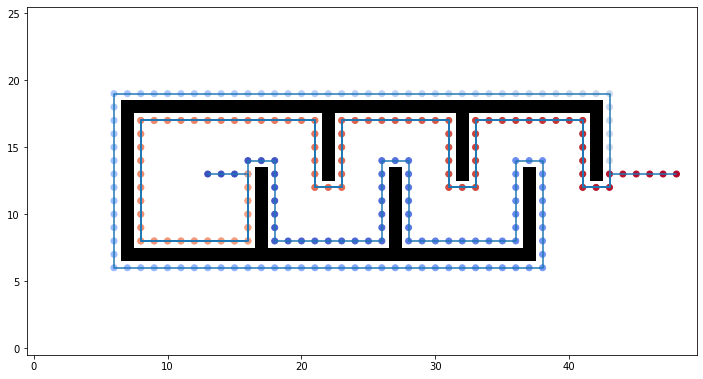

In [4]:
# qL seems to be ONE OFF -> qL1 should be 2,5 and qL2 should be either (11,10) or (10,11)
fig = plt.figure(figsize=(12,7))
plt.imshow(W.T,cmap='gray_r', origin='lower')

rgbs = plt.cm.get_cmap('coolwarm')(np.linspace(0, 1, move_history.shape[0]))
# colors = rgbs[i].reshape(1,-1)
plt.plot(np.array(move_history)[:,0],np.array(move_history)[:,1])
plt.scatter(np.array(move_history)[:,0],np.array(move_history)[:,1], c=rgbs)